<a href="https://colab.research.google.com/github/Jin-jin-jara/Small-Project1--SVHN_3_digits_classification/blob/master/small_project_SVHN_3_digits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVHN 3 digits classification

필요한 라이브러리를 임포트합니다.

In [0]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os

from scipy.io import loadmat
from skimage import color
from skimage import io

# CNN 모델을 위한 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout, BatchNormalization
from keras import optimizers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


데이터를 불러오는 함수입니다. 데이터 전처리 과정은 <a href="https://github.com/aditya9211/SVHN-CNN/blob/master/data_preprocess.ipynb">여기</a>를 참고했습니다.

In [34]:
def load_data(path):
  data = loadmat(path)
  return data['X'], data['y']

x, y = load_data("/content/drive/My Drive/test_32x32.mat")

x.shape, y.shape

((32, 32, 3, 26032), (26032, 1))

제공받은 데이터가 (높이, 너비, 채널, 데이터 수)의 형상을 갖고 있습니다. 하지만 모델에 넣을 데이터의 형상은 (데이터 수, 높이, 너비, 채널)이기 때문에 데이터의 형상을 바꿔줍니다.

In [35]:
x, y = x.transpose((3,0,1,2)), y[:, 0]

x.shape, y.shape

((26032, 32, 32, 3), (26032,))

In [0]:
m = len(y)//2

x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]

이미지를 시각화하는 함수입니다.

In [0]:
def plot_images(img, labels, nrows, ncols):

  fig, axes = plt.subplots(nrows, ncols)
  for i, ax in enumerate(axes.flat):
    if img[i].shape == (32,32,3):
      ax.imshow(img[i])
    else:
      ax.imshow(img[i,:,:,0])
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(labels[i])

이미지들을 보니 어떤 이미지들은 한 이미지 파일안에 한 숫자가 있지만, 어떤 이미지들은 좌우에 다른 숫자가 붙어 있습니다. 이런 이미지들은 모델이 숫자를 학습하는데 방해가 될 것 같습니다. 정답인 숫자들은 이미지 가운데 위치하기 때문에 좌우 픽셀들을 조금씩 잘라주면 학습하는데 더 유용할 것 같습니다.

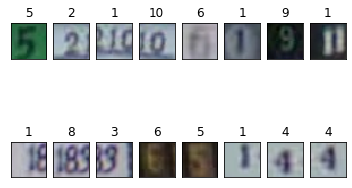

In [38]:
plot_images(x_train, y_train, 2, 8)

정답이 0인 이미지는 10으로 레이블이 되어있습니다. 정답 레이블 10을 0으로 바꿔주겠습니다.

In [39]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


In [40]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


이미지들을 붙여 3자리 숫자로 만들어주는 함수입니다. 좌우 6픽셀씩 잘라줍니다.

In [0]:
def attach_3_image(x, y):
  m = len(y)
  m = m-m%3
  pad = 6
  x, y = x[:m], y[:m]  # 3의 배수의 데이터수를 사용
  x = x[:,:, pad:-pad]  # 영상 좌우 6px 제거
  x_attach = np.concatenate((x[::3], x[1::3], x[2::3]), axis=2)
  y_attach = np.reshape(y, [-1,3])
  return x_attach, y_attach

데이터가 너무 적으면 새로운 샘플에 잘 일반화되지 않습니다. 더 많은 데이터를 학습시키기 위해 train데이터 셋을 늘려주겠습니다. 데이터를 랜덤으로 train셋에서 샘플링해 3개의 이미지를 조합하는 방법을 사용하면, 모델은 더 많은 경우를 학습할 수 있을 것입니다. 

In [42]:
rand_x = []
rand_y = []
for _ in range(10):
  rand_x_y = random.sample(list(zip(x_train, y_train)), len(x_train)//2)

  rand_x += [x[0] for x in rand_x_y]
  rand_y += [x[1] for x in rand_x_y]

rand_x = np.array(rand_x)
rand_y = np.array(rand_y)

x3_train, y3_train = attach_3_image(rand_x, rand_y)
x3_test, y3_test = attach_3_image(x_test, y_test)
x3_train.shape, y3_train.shape, x3_test.shape, y3_test.shape

((21693, 32, 60, 3), (21693, 3), (4338, 32, 60, 3), (4338, 3))

이미지를 확인해보니 3개의 이미지들이 잘 붙었습니다.

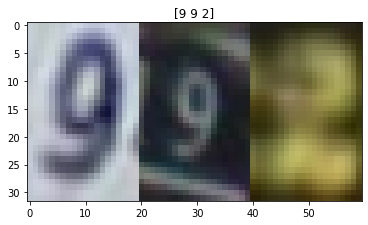

In [43]:
i = 43
plt.title(str(y3_train[i]))
plt.imshow(x3_train[i])

3차원의 rgb채널을 grayscale로 바꿔줍니다.

In [44]:
def rgb2gray(images):
  return np.expand_dims(np.dot(images, [0.2126, 0.7152, 0.0722]), axis=3)

train_grayscale = rgb2gray(x3_train).astype(np.float32)
x3_test = rgb2gray(x3_test).astype(np.float32)
train_grayscale.shape, x3_test.shape

((21693, 32, 60, 1), (4338, 32, 60, 1))

데이터들을 정규화시켜줍니다. 데이터를 정규화 시켜주면 학습을 더 빨리하고 지역 최적의 상태에 빠지게 될 가능성을 줄여줍니다. 

In [0]:
train_mean = np.mean(train_grayscale, axis=0)
train_std = np.std(train_grayscale, axis=0)
train_grayscale_norm = (train_grayscale - train_mean) / train_std

test_mean = np.mean(x3_test, axis=0)
test_std = np.std(x3_test, axis=0)
test_grayscale_norm = (x3_test - test_mean) / test_std

정규화까지 거친 데이터들의 형상을 보니 (데이터 개수, 높이, 너비, 채널)의 형상으로, 이제 데이터가 모델에 들어갈 준비를 마쳤습니다.

In [46]:
train_grayscale_norm.shape, y3_train.shape, test_grayscale_norm.shape, y3_test.shape

((21693, 32, 60, 1), (21693, 3), (4338, 32, 60, 1), (4338, 3))

정규화와 grayscale을 거친 이미지들은 출력해보겠습니다.

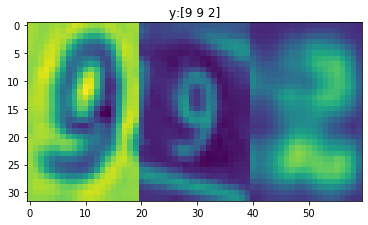

In [47]:
i = 43
plt.title('y:'+str(y3_train[i]))
plt.imshow(train_grayscale_norm[i].reshape((32,-1)))

## CNN model


배치 사이즈를 정하고 데이터를 데이터 소스로 만듭니다.

In [0]:
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_grayscale_norm, y3_train)).shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_grayscale_norm, y3_test)).shuffle(10000).batch(BATCH_SIZE)

CNN 모델은 이전에 <a href="https://github.com/Jin-jin-jara/Small-Project1---two_digits_with_blank_classification/blob/master/small_project1_two_digits_with_blank.ipynb">two_digits_with_blank_classification</a> 에서 만들어둔 모델을 가져와 수정해서 사용하겠습니다.

In [0]:
class MyModel(Model): 
  def __init__(self):
    super(MyModel, self).__init__()
    self.k = 10     # 클래스 개수 (0 ~ 9)
    self.seq = 3     # 자리수
    self.conv1 = Conv2D(128, 5, padding="same", activation="relu")
    self.pool1 = MaxPool2D(2, padding="same")
    self.conv2 = Conv2D(128, 5, padding='same', activation="relu")
    self.pool2 = MaxPool2D(2, padding="same")
    self.conv3 = Conv2D(128, 5, padding='same', activation="relu")
    self.pool3 = MaxPool2D(2, padding="same")
    self.conv4 = Conv2D(128, 5, padding='same', activation="relu")
    self.pool4 = MaxPool2D(2, padding="same")
    self.dropout = Dropout(rate=0.5)
    self.bn = BatchNormalization()
    self.flatten = Flatten()
    self.d1 = Dense(128, activation="relu")
    self.d2 = Dense(self.k*self.seq)   # 30

  def call(self, x):
    # (m, 32, 60, 1)
    x = self.conv1(x)
    x = self.bn(x)
    x = self.pool1(x)  # (m, 16, 30, 128)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.bn(x)
    x = self.pool2(x)  # (m, 8, 15, 128)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.bn(x)
    x = self.pool3(x)  # (m, 4, 8, 128)
    x = self.dropout(x)
    x = self.conv4(x)
    x = self.bn(x)
    x = self.pool4(x)   # (m, 2, 4, 128)
    x = self.flatten(x)  # (m, 1024)
    x = self.d1(x)   # (m, 128)
    x = self.dropout(x)
    h = self.d2(x)  # (m, 30)
    h = tf.reshape(h, [-1, self.seq, self.k]) # (m, 3, 10)
    h = tf.nn.softmax(h, axis=2)   
    return h

model = MyModel()


loss function, optimizer, metrics를 설정해줍니다.

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name="train_acc")

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

train과 test를 위한 함수입니다. 레이블은 one-hot encoding해주겠습니다.

In [0]:
@tf.function
def train_step(images, labels):
  y_hot = tf.one_hot(labels, depth=10, axis=-1)
  with tf.GradientTape() as tape:
    predictions = model(images) # (m, 32, 60, 1)
    loss = loss_object(y_hot, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_hot, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  y_hot = tf.one_hot(labels, depth=10, axis=-1)
  predictions = model(images)
  t_loss = loss_object(y_hot, predictions)

  test_loss(t_loss)
  test_accuracy(y_hot, predictions)

In [53]:
EPOCHS = 1000

for epoch in range(EPOCHS):
  for images, labels in train_ds: # batch size = 128씩 나눠져 들어갑니다
    train_step(images, labels)
  
  for test_images, labels in test_ds:
    test_step(test_images, labels)
  
  template = "에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}"
  
  if epoch%40==0:
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))

에포크: 0, 손실: 1.5748504400253296, 정확도: 45.1743278503418, 테스트 손실: 0.7344980239868164, 테스트 정확도: 76.01044464111328
에포크: 40, 손실: 0.07031186670064926, 정확도: 97.67423248291016, 테스트 손실: 0.6985553503036499, 테스트 정확도: 90.22647094726562
에포크: 80, 손실: 0.03952466696500778, 정확도: 98.71312713623047, 테스트 손실: 0.8079792261123657, 테스트 정확도: 90.59426879882812
에포크: 120, 손실: 0.027793817222118378, 정확도: 99.1017074584961, 테스트 손실: 0.8477137088775635, 테스트 정확도: 90.8909912109375
에포크: 160, 손실: 0.020888520404696465, 정확도: 99.32488250732422, 테스트 손실: 0.8686004281044006, 테스트 정확도: 91.22311401367188
에포크: 200, 손실: 0.01673160120844841, 정확도: 99.459228515625, 테스트 손실: 0.894518256187439, 테스트 정확도: 91.447021484375
에포크: 240, 손실: 0.013954571448266506, 정확도: 99.54898834228516, 테스트 손실: 0.919386088848114, 테스트 정확도: 91.61324310302734
에포크: 280, 손실: 0.011968156322836876, 정확도: 99.61317443847656, 테스트 손실: 0.9364020228385925, 테스트 정확도: 91.73258209228516
에포크: 320, 손실: 0.010476796887814999, 정확도: 99.661376953125, 테스트 손실: 0.9581270217895508, 테스트 정확도: 91.